<a href="https://colab.research.google.com/github/yassarmohammed87/SpaceShipTitanic-Kaggle/blob/main/Spaceship_Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle competitions download -c spaceship-titanic


  0% 0.00/299k [00:00<?, ?B/s]
100% 299k/299k [00:00<00:00, 74.5MB/s]


In [ ]:
!mkdir spaceTitanic 
!cp train.csv ./spaceTitanic/
!cp test.csv ./spaceTitanic/
!rm -rf test.csv
!rm -rf train.csv

In [1]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.8 MB 1.8 MB/s 


In [2]:
from google.colab import files
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder,OneHotEncoder
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn_pandas import CategoricalImputer
import xgboost as xgb
from catboost import CatBoostClassifier, Pool



In [3]:
df=pd.read_csv('./drive/MyDrive/spaceTitanic/train.csv')
# df['Transported']=df['Transported'].astype(np.int64)

In [ ]:
df.head(100)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0103_01,Earth,False,F/24/S,TRAPPIST-1e,24.0,False,0.0,NaN,0.0,0.0,17.0,Arlen Mclainez,True
96,0103_02,Earth,True,G/18/S,55 Cancri e,9.0,False,0.0,0.0,0.0,0.0,0.0,Shaele Mclainez,True
97,0103_03,Earth,True,G/18/S,TRAPPIST-1e,6.0,False,0.0,0.0,0.0,0.0,0.0,Fanne Mclainez,False
98,0105_01,Earth,NaN,F/21/P,TRAPPIST-1e,27.0,False,0.0,0.0,570.0,2.0,131.0,Carry Cleachrand,False


# Checking Null values

In [ ]:
df.isna().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

True     101
False     99
Name: Transported, dtype: int64

In [ ]:
def category_comp_plot(field):
  col_series=df[field].value_counts().index
  
  fig, axs = plt.subplots(1, len(col_series), figsize=(12, 5))
  for i,category in enumerate(col_series):
    plt.subplot(1,len(col_series),i+1)
    sns.countplot(data=df.loc[df[field]==category],x='Transported')
    plt.title(category)

plt.subplots_adjust(left=2,right=3)
    


<Figure size 432x288 with 0 Axes>

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


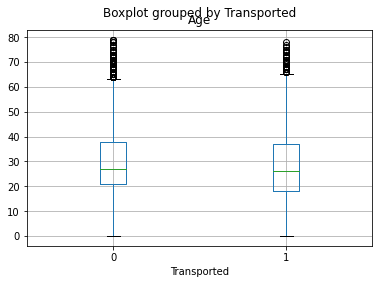

In [ ]:
df.boxplot(column='Age',by='Transported')

###**Checking significance of VIP column**

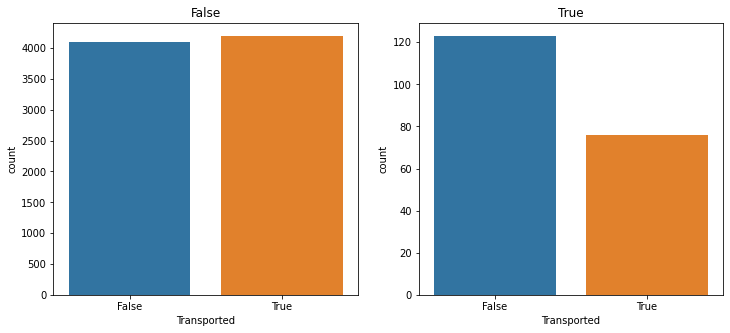

In [ ]:
category_comp_plot('VIP')


Can conclude that being a vip isnt contributing heavily to the target variable

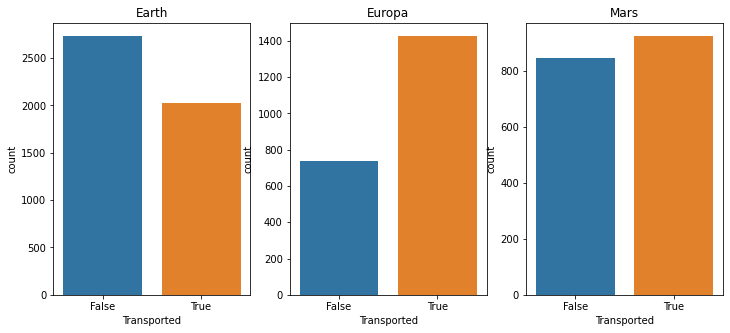

In [ ]:
category_comp_plot('HomePlanet')

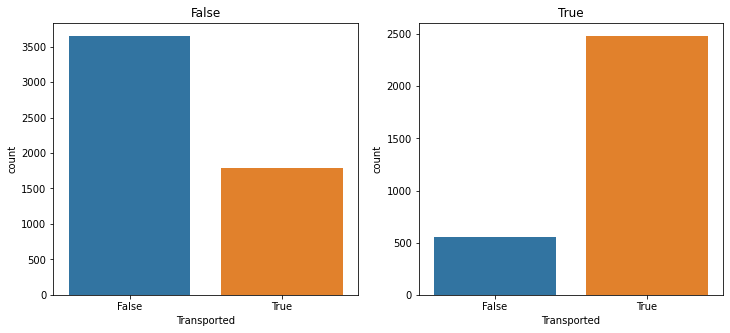

In [ ]:
category_comp_plot('CryoSleep')

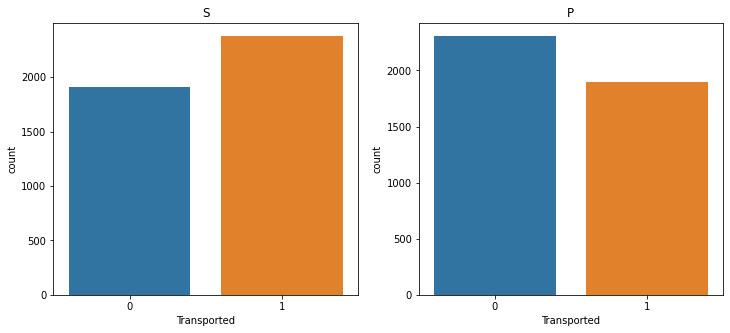

In [ ]:
df['Port']=df['Cabin'].str[-1]
category_comp_plot('Port')

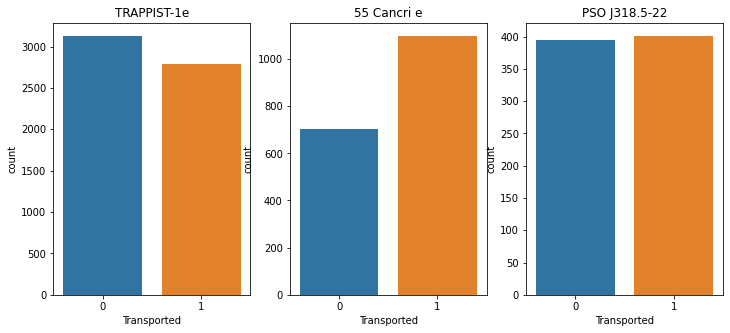

In [ ]:
category_comp_plot('Destination')

# Transformers

In [171]:
class cat_Imputer(BaseEstimator,TransformerMixin):
  def __init__(self,categ_cols):
    self.categ_cols=categ_cols
  def fit(self,X,y=None):
    return self
  def transform(self,X,y=None):
    
    
    true_transported=X['Transported'].value_counts().loc[True]
    false_transported=X['Transported'].value_counts().loc[False]
    for i in self.categ_cols:
      true_prob=[]
      false_prob=[]
      tp=X.loc[~X[i].isna()].copy(deep=True)
      
      for j in tp[i].value_counts().index:
        true_prob.append(tp.loc[(X[i]==j) & (tp['Transported']==True)].shape[0]/true_transported)
        false_prob.append(tp.loc[(X[i]==j) & (tp['Transported']==False)].shape[0]/false_transported)

        # try:
        #   true_prob.append(X[~df[i].isna()].groupby('Transported').agg({i:[(j,lambda x:x.str.count().sum()/true_transported)]}).loc[True][(i,j)])
        #   false_prob.append(X[~df[i].isna()].groupby('Transported').agg({i:[(j,lambda x:x.str.count().sum()/false_transported)]}).loc[False][(i,j)])
        # except:
        #   true_prob.append(X[~df[i].isna()].groupby('Transported').agg({i:[(j,lambda x:x.count().sum()/true_transported)]}).loc[True][(i,j)])
        #   false_prob.append(X[~df[i].isna()].groupby('Transported').agg({i:[(j,lambda x:x.count().sum()/false_transported)]}).loc[False][(i,j)])
      X.loc[(X[i].isna()) & (X['Transported']==True),i]=np.random.choice(X[i].value_counts().index,
                                                                                X.loc[(X[i].isna()) & (X['Transported']==True),i].shape,
                                                                                p=true_prob/sum(true_prob))
      X.loc[(X[i].isna()) & (X['Transported']==False),i]=np.random.choice(X[i].value_counts().index,
                                                                                X.loc[(X[i].isna()) & (X['Transported']==False),i].shape,
                                                                                p=true_prob/sum(true_prob))
    
    return X

class Int_Imputer(BaseEstimator,TransformerMixin):
  def __init__(self,cols):
    self.cols=cols
  def fit(self,X,y=None):
    return self
  def transform(self,X,y=None):
    imputer=SimpleImputer(strategy="median")
    imputer.fit(X[self.cols])
    X[self.cols]=imputer.transform(X[self.cols])
  
    return X
  


class AttriAdder(BaseEstimator,TransformerMixin):

  def __init__(self):
    pass
  def fit(self,X,y=None):
    return self
  def transform(self,X,y=None):
    X['TotalSpent']=X['RoomService']+X['Spa']+X['VRDeck']
    X['P_ID1']=X['PassengerId'].str.split('_').apply(lambda x:x[0])    
    X['P_ID2']=X['PassengerId'].str.split('_').apply(lambda x:x[1])
    # 

    return X


class OrdEncoding(BaseEstimator,TransformerMixin):

  def __init__(self,cols):
    self.cols=cols
  def fit(self,X,y=None):
    return self
  def transform(self,X,y=None):
    ord=OrdinalEncoder()
    for col in self.cols:
      X[col]=ord.fit_transform(X[[col]])

    return X

class OneHot(BaseEstimator,TransformerMixin):

  def __init__(self,cols):
    self.cols=cols
  def fit(self,X,y=None):
    return self
  def transform(self,X,y=None):
    
    for col in self.cols:
      one=OneHotEncoder(sparse=False)
      X[list(one.categories_[0])]=one.fit_transform(X[[col]])
      print(list(one.categories_[0]))

    return X

class TypeChange(BaseEstimator,TransformerMixin):

  def __init__(self,cols_dict):
    self.cols_dict=cols_dict
  def fit(self,X,y=None):
    return self
  def transform(self,X,y=None):
    for col in self.cols_dict:
      X[col]=X[col].astype(self.cols_dict[col])
    return X

class Dropcols(BaseEstimator,TransformerMixin):

  def __init__(self,to_drop):
    self.to_drop=to_drop
  def fit(self,X,y=None):
    return self
  def transform(self,X,y=None):
    X=X.drop(columns=self.to_drop,axis=1)
    return X

class Keepcols(BaseEstimator,TransformerMixin):

  def __init__(self,to_keep):
    self.to_keep=to_keep
  def fit(self,X,y=None):
    return self
  def transform(self,X,y=None):
    X=X[self.to_keep]
    return X

class Scaler(BaseEstimator,TransformerMixin):
  def __init__(self,cols=None):
    self.cols=cols
    pass
  def fit(self,X,y=None):
    return self
  def transform(self,X,y=None):
    if self.cols==None:
      self.cols=X.columns
    scaler=StandardScaler()
    X[self.cols]=scaler.fit_transform(X[self.cols])
    return X

class ModeImputer(BaseEstimator,TransformerMixin):
  def __init__(self,cols):
    self.cols=cols
    
  def fit(self,X,y=None):
    return self
  def transform(self,X,y=None):
    for i in self.cols:
      cat_imputer=CategoricalImputer()
      X[i]=cat_imputer.fit_transform(X[i])
    return X

class Binner(BaseEstimator,TransformerMixin):
  def __init__(self,cols,cats=4):
    self.cols=cols
    self.cats=cats
  def fit(self,X,y=None):
    return self
  def transform(self,X,y=None):
    for i in self.cols:
      X[i]=pd.qcut(X[i],self.cats,labels=False)
    return X

class Value_Imputer(BaseEstimator,TransformerMixin):
  def __init__(self,col_val):
    self.col_val=col_val
  def fit(self,X,y=None):
    return self
  def transform(self,X,y=None):
    for i in self.col_val:
      X[i]=X[i].fillna(value=self.col_val[i])
    return X


# Functions for test dataset

In [252]:
def split(dataset,label_name):
  dataset=dataset.sample(frac=1,random_state=42)
  labels=dataset[label_name]
  dataset=dataset.drop(columns=[label_name])
  train,test,train_labels,test_labels=train_test_split(dataset,labels,test_size=0.1,random_state=42)
  return {'train':train,'train_labels':train_labels,'test':test,'test_labels':test_labels}

In [306]:
df=pd.read_csv('./drive/MyDrive/spaceTitanic/train.csv')
train,train_labels,test,test_labels=split(df,'Transported').values()
train_labels=train_labels.astype(np.int64)
test_labels=test_labels.astype(np.int64)

# Adding Side from Cabin

In [307]:
train['side']=train['Cabin'].str[-1]
test['side']=test['Cabin'].str[-1]


# Imputing HomePlanet

In [308]:
def HomePlanetImpute(df):
  df['deck']=df['Cabin'].str[0]
  deck_to_cab={'A':'Europa','C':'Europa','B':'Europa','T':'Europa','D':'Mars','E':'Earth','G':'Earth','F':'Earth'}
  for i in deck_to_cab:
    df.loc[(df['deck']==i) & df['HomePlanet'].isna(),'HomePlanet']=df.loc[(df['deck']==i) & df['HomePlanet'].isna(),'HomePlanet'].fillna(
        value=deck_to_cab.get(i,'F'))
  return df

In [309]:
train=HomePlanetImpute(train)
test=HomePlanetImpute(test)

In [163]:
int_imp=Int_Imputer(['Age','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck'])
df=int_imp.fit_transform(df)
# val_imp=Value_Imputer({'Name':'Random Random'})
# df=val_imp.fit_transform(df)
attri_adder=AttriAdder()
df=attri_adder.fit_transform(df)
binner=Binner(['Age'],4)
df=binner.fit_transform(df)
modeImp=ModeImputer(['HomePlanet','CryoSleep','side','Destination','VIP'])
df=modeImp.fit_transform(df)
type_change=TypeChange({'Transported':np.int64})
df=type_change.fit_transform(df)
one_hot=OneHot(['HomePlanet','side','Destination','P_ID2'])
df=one_hot.fit_transform(df)
# drp_cls=Dropcols(['Name','Cabin','Destination','HomePlanet','side','PassengerId','RoomService','VRDeck','Spa'])
# df=drp_cls.fit_transform(df)
# bin=Binner(['Age'],4)
# df=bin.fit_transform(df)
# keep_cls=Keepcols(['TotalSpent','Earth','Europa','CryoSleep','Transported'])
# non_cat_df=keep_cls.fit_transform(df)
keep_cls=Keepcols(['RoomService','Spa','VRDeck','HomePlanet','Transported','CryoSleep','side','Destination','P_ID2','VIP','Age'])
cat_df=keep_cls.fit_transform(df)
scaler=Scaler(['RoomService','Spa','VRDeck','Age'])
cat_df=scaler.fit_transform(cat_df)
# xg_df=scaler.fit_transform(xg_df)

KeyError: ignored

In [22]:
df['Destination'].mode().values[0]

'TRAPPIST-1e'

# Non Cat Pipeline

In [299]:
from sklearn.pipeline import Pipeline


In [279]:

non_Pipe=Pipeline([('val_imp',Value_Imputer({'Age':train['Age'].mean(),'RoomService':train['RoomService'].mean(),
                                            'FoodCourt':train['FoodCourt'].mean(),'ShoppingMall':train['ShoppingMall'].mean()
                                            ,'Spa':train['Spa'].mean(),'VRDeck':train['VRDeck'].mean(),
                                            'HomePlanet':train['HomePlanet'].mode().values[0],
                                            'CryoSleep':train['CryoSleep'].mode().values[0],
                                            'Destination':train['Destination'].mode().values[0],
                                            'VIP':train['VIP'].mode().values[0]})),
                    ('attri_adder',AttriAdder()),
                    ('val_imp2',Value_Imputer({'side':train['side'].mode().values[0]})),
                    ('binner',Binner(['Age'],4)),
                    ('typ_change',TypeChange({'CryoSleep':np.int64,'VIP':np.int64})),
                    ('one_hot',OneHot(['HomePlanet','side','Destination','P_ID2'])),
                    ('keep_cls',Keepcols(['TotalSpent','Earth','Europa','CryoSleep','P','VIP','Age',
                                          'TRAPPIST-1e','55 Cancri e','PSO J318.5-22',
                                          '01','02','03','04','05','06','07','08'])),
                    ('scaler',Scaler(['TotalSpent','CryoSleep','VIP','Age']))
                    ],verbose=False)



In [280]:
train=non_Pipe.fit_transform(train)
test=non_Pipe.fit_transform(test)

['Earth', 'Europa', 'Mars']
['P', 'S']
['55 Cancri e', 'PSO J318.5-22', 'TRAPPIST-1e']
['01', '02', '03', '04', '05', '06', '07', '08']
['Earth', 'Europa', 'Mars']
['P', 'S']
['55 Cancri e', 'PSO J318.5-22', 'TRAPPIST-1e']
['01', '02', '03', '04', '05', '06', '07', '08']


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


# Cat Pipeline

In [310]:
cat_Pipe=Pipeline([('val_imp',Value_Imputer({'Age':train['Age'].mean(),'RoomService':train['RoomService'].mean(),
                                            'FoodCourt':train['FoodCourt'].mean(),'ShoppingMall':train['ShoppingMall'].mean()
                                            ,'Spa':train['Spa'].mean(),'VRDeck':train['VRDeck'].mean(),
                                            'HomePlanet':train['HomePlanet'].mode().values[0],
                                            'CryoSleep':train['CryoSleep'].mode().values[0],
                                            'Destination':train['Destination'].mode().values[0],
                                            'VIP':train['VIP'].mode().values[0],'Name':'Random Random'})),
                    ('attri_adder',AttriAdder()),
                    ('val_imp2',Value_Imputer({'side':train['side'].mode().values[0]})),
                    ('binner',Binner(['Age'],4)),
                    ('keep_cls',Keepcols(['TotalSpent','HomePlanet','CryoSleep','side','VIP','Age',
                                          'Destination',
                                          'P_ID2','Name'])),
                    ('scaler',Scaler(['TotalSpent','Age']))
                    ],verbose=False)


In [311]:
cat_train=cat_Pipe.fit_transform(train)
cat_test=cat_Pipe.fit_transform(test)
cat_train['lastName']=cat_train['Name'].str.split(' ').apply(lambda x:x[1])
cat_train.drop(columns=['Name'],inplace=True)
cat_test['lastName']=cat_test['Name'].str.split(' ').apply(lambda x:x[1])
cat_test.drop(columns=['Name'],inplace=True)



/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

In [305]:
cat_train['lastName']

118           Mish
3902           Fla
2292    Johnshines
3776    Waltonnedy
808        Lambles
           ...    
2023         Graie
7571       Pulgaly
4628       Alenter
1330        Foxter
74       Vinozarks
Name: lastName, Length: 7823, dtype: object

In [200]:
test

,TotalSpent,Earth,Europa,CryoSleep,P,VIP,Age,TRAPPIST-1e,55 Cancri e,PSO J318.5-22,01,02,03,04,05,06,07,08
4640,990.0,0.0,0.0,-0.757124,1.0,-0.14535,0.479769,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1443,539.0,0.0,0.0,-0.757124,1.0,-0.14535,-0.415937,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
606,944.0,1.0,0.0,-0.757124,0.0,-0.14535,0.479769,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
6651,0.0,1.0,0.0,1.320787,0.0,-0.14535,0.479769,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6944,1236.0,0.0,0.0,-0.757124,1.0,-0.14535,1.375476,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5243,210.0,1.0,0.0,-0.757124,0.0,-0.14535,-1.311644,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7258,791.0,1.0,0.0,-0.757124,1.0,-0.14535,-0.415937,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5863,0.0,0.0,0.0,-0.757124,1.0,-0.14535,-1.311644,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3276,0.0,1.0,0.0,1.320787,1.0,-0.14535,-1.311644,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [205]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
import joblib
from sklearn.model_selection import cross_validate
from sklearn.ensemble import VotingClassifier

## Function For HyperParamter Tuning

In [ ]:
def randomSearcher(model,params,name,train,train_labels):
  rs=RandomizedSearchCV(model,param_distributions=params,scoring='accuracy',n_iter=20)
  rs.fit(train,train_labels)
  joblib.dump(rs.best_estimator_,'./drive/MyDrive/spaceTitanic/models/'+name)


# Ada Boost HyperParameter Tuning

In [ ]:
max_depth=[int(x) for x in np.linspace(10,110,num=11)]
ada_params = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "base_estimator__max_depth":max_depth
             }
dtree=DecisionTreeClassifier(random_state=42)
abc=AdaBoostClassifier(dtree)
randomSearcher(abc,ada_params,'abc_h_noTotalSpent')
abc=joblib.load('./drive/MyDrive/spaceTitanic/models/abc_h_noTotalSpent')



In [ ]:
abc=joblib.load('./drive/MyDrive/spaceTitanic/models/abcBestMode')

# SVC HyperParameter Tuning

In [ ]:
svc_params = {'C': [0.1, 1, 10],'kernel':['linear','poly','rbf']}
svc=SVC()
randomSearcher(svc,svc_params,'svc_h_classic')
svc=joblib.load('./drive/MyDrive/spaceTitanic/models/svc_h_classic')


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 9 is smaller than n_iter=20. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


# Random Forest HyperParameter Tuning

In [ ]:
n_estimators=[int(x) for x in np.linspace(start=10,stop=100,num=10)]
max_features=['auto','sqrt']
max_depth=[int(x) for x in np.linspace(10,110,num=11)]
max_depth.append(None)
min_samples_split=[2,5,10]
min_samples_leaf=[1,2,4]
bootstrap=[True,False]
rdm_params={'n_estimators':n_estimators,'max_features':max_features,'max_depth':max_depth,'min_samples_split':min_samples_split
                           ,'min_samples_leaf':min_samples_leaf,'bootstrap':bootstrap}
rf=RandomForestClassifier()
randomSearcher(rf,rdm_params,'rf_h_noTotalSpent')
rf=joblib.load('./drive/MyDrive/spaceTitanic/models/rf_h_noTotalSpent')


# Support Vector Machine

In [213]:
svc=SVC(probability=True)
# svc.fit(train,train_labels)


# Voting Classifier

In [217]:
vC=VotingClassifier(estimators=[('xg',xg),('svc',svc)],voting='hard')
vC.fit(train,train_labels)

VotingClassifier(estimators=[('xg', XGBClassifier()),
                             ('svc', SVC(probability=True))])

In [219]:
accuracy_score(test_labels,vC.predict(test))

0.7735632183908046

## XG BOOST

In [247]:
xg=xgb.XGBClassifier()
xg.fit(train,train_labels)
accuracy_score(test_labels,xg.predict(test))

0.8011494252873563

In [281]:
accuracy_score(train_labels,xg.predict(train))

0.7948357407644127

In [221]:
dtree=DecisionTreeClassifier(random_state=42)
abc=AdaBoostClassifier(dtree)
abc.fit(train,train_labels)
accuracy_score(test_labels,abc.predict(test))

0.7620689655172413

## CatBoost Classifier

In [312]:
# cat_params = {'learning_rate': [0.01,0.03, 0.1],
#         'depth': [4, 6, 10,15,20],
#         }
cat_model=CatBoostClassifier(cat_features=['HomePlanet','side','P_ID2','CryoSleep','VIP','Destination','lastName'],eval_metric='Accuracy',depth=12, l2_leaf_reg=1, learning_rate=0.03)
# randomSearcher(cat_model,cat_params,'cat_all',cat_df,labels)

# model_CBC2 = CatBoostClassifier(cat_features=['HomePlanet','side','P_ID2','CryoSleep','VIP','Destination'],eval_metric='Accuracy',depth=12, l2_leaf_reg=1, learning_rate=0.03)
# model_CBC2.fit(cat_train,cat_train_labels,eval_set=(cat_test, cat_test_labels),verbose=False,early_stopping_rounds=200,use_best_model=True)

In [313]:
cat_model.fit(cat_train,train_labels,eval_set=(cat_test,test_labels),verbose=False,early_stopping_rounds=200,use_best_model=True)

In [266]:
cat_model.best_score_

{'learn': {'Accuracy': 0.8255145085005752, 'Logloss': 0.37279664583472405},
 'validation': {'Accuracy': 0.8011494252873563, 'Logloss': 0.4256381292634476}}

In [314]:
cat_model.best_score_

{'learn': {'Accuracy': 0.9002940048574716, 'Logloss': 0.2738857747466765},
 'validation': {'Accuracy': 0.8022988505747126,
  'Logloss': 0.42646634671084555}}

In [282]:
(cat_model.predict(cat_test)==xg.predict(test)).sum()

854

In [315]:
for i,j in zip(cat_model.feature_names_,cat_model.feature_importances_):
  print(f'{i}:{j}')

TotalSpent:21.255240165023526
HomePlanet:19.024444893246898
CryoSleep:7.3932735190826495
side:10.30450415715907
VIP:0.25100294377823246
Age:9.478076526259134
Destination:11.207167630657237
P_ID2:11.367097758908832
lastName:9.719192405884451


## Logging Scores

In [224]:
def score_logger(train,test,train_labels,test_labels,model):
  model.fit(train,train_labels)
  training_acc=accuracy_score(train_labels,model.predict(train))
  test_acc=accuracy_score(test_labels,model.predict(test))
  score_log=pd.read_csv('./drive/MyDrive/spaceTitanic/score_log.csv')
  emp=','.join(train.columns)
  score_log=score_log.append(pd.DataFrame({'Columns':emp,'Training Accuracy':training_acc,'Test Accuracy':test_acc,'Model':model.__class__.__name__},index=range(0,1)),ignore_index=True)
  score_log.to_csv('./drive/MyDrive/spaceTitanic/score_log.csv',index=False)
  # files.download('./drive/MyDrive/spaceTitanic/score_log.csv')
  print(score_log)

  
  


In [225]:
score_logger(train,test,train_labels,test_labels,xg)

                                              Columns  Training Accuracy  \
0                          TotalSpent,CryoSleep,Earth           0.800205   
1                   TotalSpent,CryoSleep,Earth,Europa           0.809408   
2                   TotalSpent,CryoSleep,Earth,Europa           0.809792   
3   TotalSpent,CryoSleep,Earth,Europa,P,S,55 Cancri e           0.814266   
4                   TotalSpent,CryoSleep,Earth,Europa           0.807619   
5                   TotalSpent,CryoSleep,Earth,Europa           0.785504   
6                   TotalSpent,CryoSleep,Earth,Europa           0.785249   
7                   TotalSpent,CryoSleep,Earth,Europa           0.789978   
8                   TotalSpent,CryoSleep,Earth,Europa           0.851719   
9                   TotalSpent,CryoSleep,Earth,Europa           0.808386   
10                  TotalSpent,CryoSleep,Earth,Europa           0.850697   
11                  TotalSpent,CryoSleep,Earth,Europa           0.786655   
12          

In [ ]:
score_log=pd.read_csv('./drive/MyDrive/spaceTitanic/score_log.csv')


#Test Data

In [316]:
testKag=pd.read_csv('./drive/MyDrive/spaceTitanic/test.csv')
df=pd.read_csv('./drive/MyDrive/spaceTitanic/train.csv')

In [317]:
testKag['side']=testKag['Cabin'].str[-1]
Passenger_ids=testKag['PassengerId']
testKag=HomePlanetImpute(testKag)
testKag=cat_Pipe.fit_transform(testKag)
testKag['lastName']=testKag['Name'].str.split(' ').apply(lambda x:x[1])
testKag.drop(columns=['Name'],inplace=True)


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

In [ ]:
# int_imp=Int_Imputer(['Age','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck'])
# testKag=int_imp.fit_transform(testKag)
val_imp=Value_Imputer({'RoomService':df['RoomService'].mean(),'Spa':df['Spa'].mean(),'VRDeck':df['VRDeck'].mean(),
                       'HomePlanet':df['HomePlanet'].mode().values[0],'Destination':df['Destination'].mode().values[0],
                       'CryoSleep':df['CryoSleep'].mode().values[0],'VIP':df['VIP'].mode().values[0],
                       })
testKag=val_imp.fit_transform(testKag)
attri_adder=AttriAdder()
testKag=attri_adder.fit_transform(testKag)
testKag['side']=testKag['side'].fillna(value=cat_df['side'].mode().values[0])
# modeImp=ModeImputer(['HomePlanet','CryoSleep','side','Destination','VIP'])
# testKag=modeImp.fit_transform(testKag)
# type_change=TypeChange({'CryoSleep':np.int64,'VIP':np.int64})
# testKag=type_change.fit_transform(testKag)
# one_hot=OneHot(['HomePlanet','side','Destination','P_ID2'])
# testKag=one_hot.fit_transform(testKag)
# drp_cls=Dropcols(['Name','Cabin','Destination','HomePlanet','side','PassengerId','RoomService','VRDeck','Spa'])
# df=drp_cls.fit_transform(df)
# bin=Binner(['Age'],4)
# testKag=bin.fit_transform(testKag)
keep_cls=Keepcols(['TotalSpent','HomePlanet','side','P_ID2','CryoSleep','VIP','Destination'])
cat_testKag=keep_cls.fit_transform(testKag)
scaler=Scaler(['TotalSpent'])
cat_testKag=scaler.fit_transform(cat_testKag)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


In [ ]:
fully_trained_cat=joblib.load('./drive/MyDrive/spaceTitanic/cat_all')
predictions=pd.DataFrame({'PassengerId':testKag['PassengerId'],'Transported':fully_trained_cat.predict(cat_testKag).astype('bool')})
predictions.to_csv('./drive/MyDrive/spaceTitanic/full_cat_preds.csv')

In [236]:
def answer_dumper(model,file_name,df,ids):
  predictions=pd.DataFrame({'PassengerId':ids,'Transported':model.predict(df).astype('bool')})
  predictions.to_csv('./drive/MyDrive/spaceTitanic/'+file_name+'.csv')

In [318]:

answer_dumper(cat_model,'cat_with_lastName',testKag,Passenger_ids)